### The idea

The term fake news gained prominence during the last US election, but have been around for a while. The problem is that now they have saturated the media landscape with ever more scandalous titles, and have reached a point where it is difficult to tell the fake from real. They are widely used for political purposes and supposedly shaped the last US elections and are part of the widespread russian hybrid war. 

The goal of this "excercise" is to explore these fake news: Where do they come from? What is in them? What topics get the most involvement? Finally I will try to build a classifier that tries to tell fake from clickbait from real news, and a fake news generator, that will hopefully capture the essence.


### Plan of attack 

1. Which media have the most fake news in the dataset?
    Looks like the way the dataset is constructed you get at most 100 titles from a media. So not the best metric        
2. What are the most common words and bigrams you find in titles? +
3. What are the most common words and bigrams you find in texts? +
4. What topics get the most interest (likes, shares and comments)?
5. Which medias get the most interest (likes, shares and comments)? +
6. Can we build fake news classifier:
    - Need to get non-fake-news data.
    - Would it work by title only?
    - Classify fake news, clickbait, real_news
    - T-SNE, clustering and other visualisation. 
    - Word distributions in different groups
    - Deep vs traditional
    - word2vec vs. tf-idf
7. How often do capital letters appear in titles? Can we use these as a predictor?
8. What do the texts of the articles tell us - can we find common patterns, topics, etc.? +
9. Can we build a fake news generator?
    - GAN? Nope.
    - RNN or something?
10. Obtain more news to see if the set reflects current state of fake news media. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import matplotlib.style as style
style.use('fivethirtyeight')
# TODO - Stemming

In [2]:
%matplotlib inline

In [3]:
n_samples = 2000
n_features = 1000
n_components = 6
n_top_words = 12

stopwords = list(set(stopwords.words('english')))
generic_stopwords = [ '-', '&', '|', 'http','https', 'share', 
                      'tags', 'html','com', 'www', 'twitter',
                      'infowars', 'infowarsstore',
                      'brain force']
sns.set()

In [4]:
def make_wordcloud(texts, stopwords, title="Wordcloud", plot=True):
    """
    Helper function that will plot a word cloud from a text or list of texts
    """
    if type(texts) is list:
        texts = ' '.join(texts)
    texts = texts.lower()
    wordcloud = WordCloud(max_font_size=70,
                          background_color="white",
                          max_words=2000,
                          collocations=False,
                          width=400,
                          height=400,
    
                          stopwords=stopwords).generate(texts)
    if not plot:
        return wordcloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    

def print_top_words(model, feature_names, n_top_words):
    
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def get_topics(texts):
    
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words=stopwords)
    tfidf = tfidf_vectorizer.fit_transform(texts)
    nmf = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5).fit(tfidf)

    print("\nTopics in NMF model (Frobenius norm):")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words)

In [5]:

# Prepare and clean data
data = pd.read_csv("fake.csv", header=0)
print(set(data.language))
print(set(data.type))
# We want only english on this one. Unfortunately reduces the dataset down to a third of its original size
data = data[data.language == 'english'] 
data = data.dropna()

{'norwegian', 'dutch', 'italian', 'arabic', 'greek', 'german', 'portuguese', 'polish', 'russian', 'turkish', 'finnish', 'english', 'french', 'spanish', 'chinese', 'ignore'}
{'junksci', 'bias', 'fake', 'conspiracy', 'satire', 'state', 'bs', 'hate'}


In [6]:
data.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [7]:
satire = data[data.type=='satire']
consp = data[data.type=='conspiracy']
consp = consp[~consp.text.str.contains("Brain Force")]
state = data[data.type=='state']
bs = data[data.type=='bs']
bias = data[data.type=='bias']
fake = data[data.type=='fake']
junksci = data[data.type=='junksci']
hate = data[data.type=='hate']
data = data[~data.text.str.contains("Brain Force")]

In [8]:
infowars = data[data.site_url=='infowars.com']
print(infowars.shape)
for i in range(infowars.shape[0]):
    #print(list(infowars.title)[i])
    if "tzrwu" in list(infowars.text)[i]:
        print(list(infowars.title)[i])
        print(list(infowars.text)[i])
        print("-------")
# 81 out of 200 contan legit titles but the text is just an advertisement

for i in range(infowars.shape[0]):
    #print(list(infowars.title)[i])
    if "Brain Force" in list(infowars.text)[i]:
        print(list(infowars.title)[i])
        print(list(infowars.text)[i])
        print("-------")
# 81 out of 200 contan legit titles but the text is just an advertisement

(81, 20)


### Dataset type composition

By far the most news are the ones labelled as 'bs'. Seems that this category is a throw it all that features a lot of data that would otherwise be in another category. Biased news, conspiracy theories, hate news and junkscience follow. Now the question here is how much does this distributon capture what is actually out there and is there a way to get an idea for that? I will try to come back to that later.

[('junksci', 97), ('bias', 271), ('fake', 2), ('conspiracy', 144), ('state', 6), ('bs', 3737), ('hate', 99)]


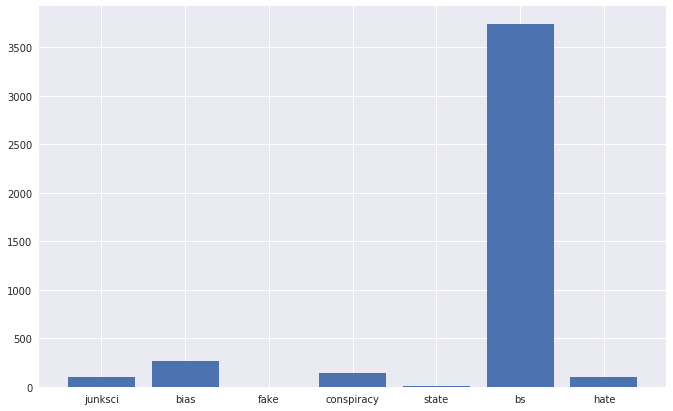

In [9]:
types = set(data.type)
sizes = []
for t in types:
    sizes.append((t, data[data.type==t].shape[0]))
print(sizes)

plt.figure(figsize=[10,7])
plt.bar(left = [x for x in range(len(types))], height = [x[1] for x in sizes])
plt.xticks([x for x in range(len(types))], [x[0] for x in sizes])
plt.show()

### Wordclouds

Lets have a look at the wordclouds of the texts of the news in the major categories. 
Initially all clouds had the names of the presidential candidates as well as former president Obama feature prominently.
So, I added them to the stopwords, to see what else is there. 

At a first glance most wordclouds feature some of the same prominent words, yet have their own slant. The junk
science news seem to stand on its own, as it features a lot more health related words. Most other 'fake news'
seem to be overly political. 

It seems there is quite the little marketing campaign going on in conspiracy. Might also be the case that most of those news come exclusively from infowars. 

Next step would be comparing word distributions and trying to do PCAs, clustering, etc. 



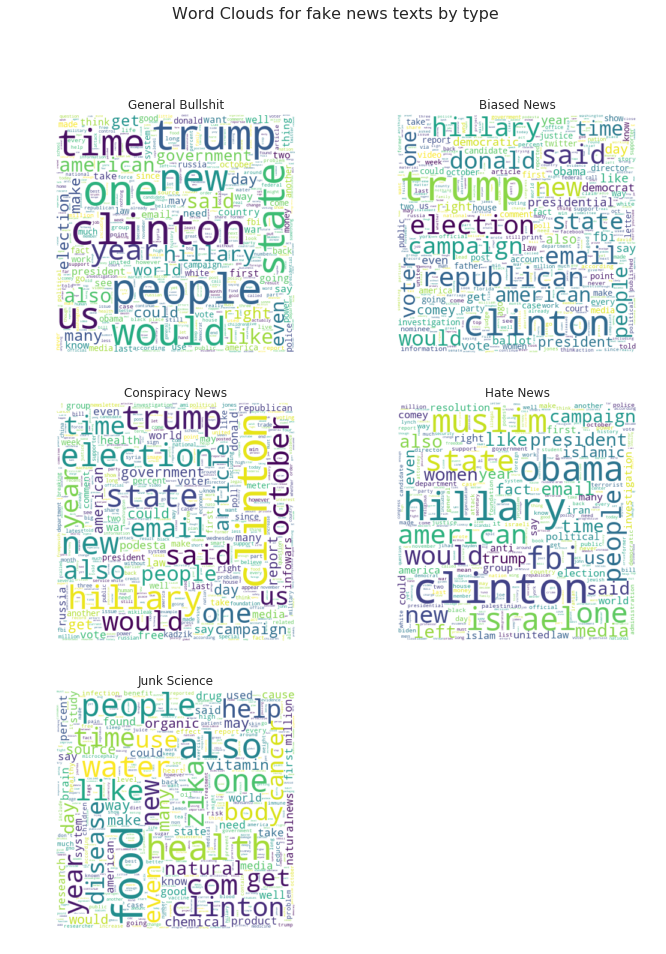

In [10]:
n_cols = 2
n_rows = 3

f, axes = plt.subplots(n_rows, n_cols, figsize=[10,15], sharex='all', sharey='all')
#print(axes)
plt.suptitle("Word Clouds for fake news texts by type", fontsize=16)
axes[0, 0].imshow(make_wordcloud(list(bs.text), stopwords, "General Bullshit", plot=False), interpolation="bilinear")
axes[0, 0].set_title("General Bullshit")
axes[0, 0].axis("off")
axes[0 ,1].imshow(make_wordcloud(list(bias.text), stopwords, "Biased News", plot=False), interpolation="bilinear")
axes[0, 1].set_title("Biased News")
axes[0, 1].axis("off")
axes[1, 0].imshow(make_wordcloud(list(consp.text), stopwords, "Conspiracy news", plot=False), interpolation="bilinear")
axes[1, 0].set_title("Conspiracy News")
axes[1, 0].axis("off")
axes[1, 1].imshow(make_wordcloud(list(hate.text), stopwords, "Hate news", plot=False), interpolation="bilinear")
axes[1, 1].set_title("Hate News")
axes[1, 1].axis("off")

axes[2, 0].imshow(make_wordcloud(list(junksci.text), stopwords, "Fake Science news", plot=False), interpolation="bilinear")
axes[2, 0].set_title("Junk Science")
axes[2, 0].axis("off")
axes[2, 1].axis("off")

plt.show()



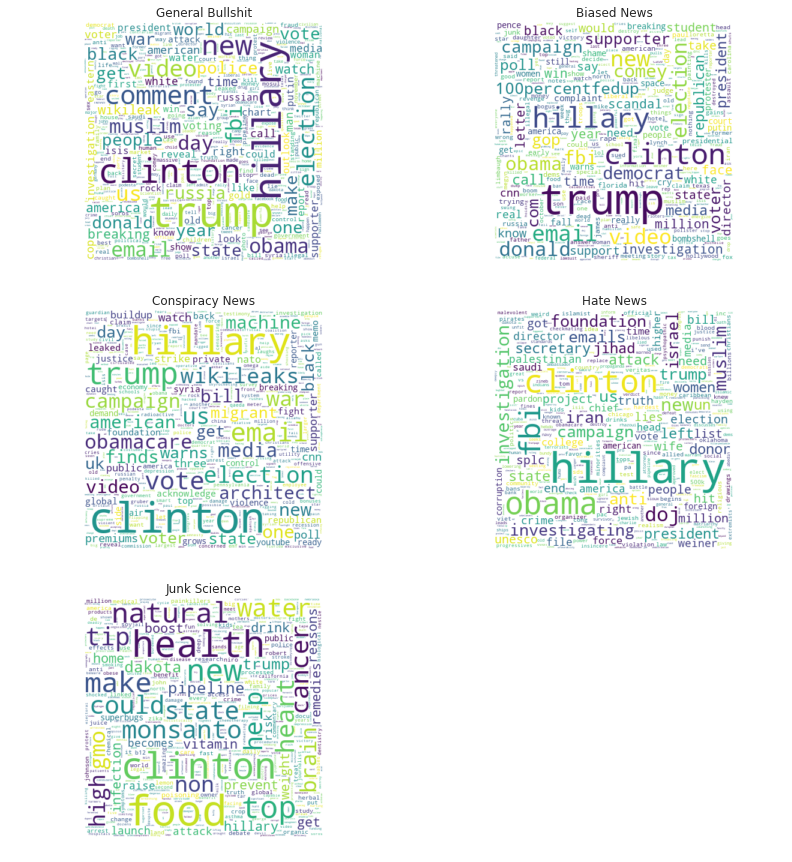

In [11]:
n_cols = 2
n_rows = 3

f, axes = plt.subplots(n_rows, n_cols, figsize=[12,15], sharex='all', sharey='all')
#print(axes)
plt.suptitle("Word Clouds for fake news Titles by type", fontsize=16)
axes[0, 0].imshow(make_wordcloud(list(bs.title), stopwords, "General Bullshit", plot=False), interpolation="bilinear")
axes[0, 0].set_title("General Bullshit")
axes[0, 0].axis("off")
axes[0 ,1].imshow(make_wordcloud(list(bias.title), stopwords, "Biased News", plot=False), interpolation="bilinear")
axes[0, 1].set_title("Biased News")
axes[0, 1].axis("off")
axes[1, 0].imshow(make_wordcloud(list(consp.title), stopwords, "Conspiracy news", plot=False), interpolation="bilinear")
axes[1, 0].set_title("Conspiracy News")
axes[1, 0].axis("off")
axes[1, 1].imshow(make_wordcloud(list(hate.title), stopwords, "Hate news", plot=False), interpolation="bilinear")
axes[1, 1].set_title("Hate News")
axes[1, 1].axis("off")

axes[2, 0].imshow(make_wordcloud(list(junksci.title), stopwords, "Fake Science news", plot=False), interpolation="bilinear")
axes[2, 0].set_title("Junk Science")
axes[2, 0].axis("off")
axes[2, 1].axis("off")
plt.show()


In [43]:
# TODO:Smarter cleanup and apply to dataset. This is shit
import re
full_data = " ".join(list(data.title)).lower()
full_data = re.sub(r'[^\x00-\x7f]',"",full_data) 
full_data = re.sub(r"\d+", "", full_data)

words = [x for x in full_data.split(" ") if x not in stopwords]

bigrams = list(nltk.bigrams(words))
fdist = nltk.FreqDist(bigrams)
print(fdist.most_common(100))

[(('hillary', 'clinton'), 115), (('donald', 'trump'), 76), (('|', 'new'), 44), (('new', 'eastern'), 44), (('eastern', 'outlook'), 44), (('standing', 'rock'), 41), (('chart', 'day:'), 37), (('fbi', 'director'), 26), (('hillary', 'clintons'), 25), (('comment', ''), 25), (('clinton', 'campaign'), 23), (('clinton', 'foundation'), 23), (('trump', 'supporters'), 22), (('bill', 'clinton'), 21), ((':', 'daily'), 21), (('daily', 'contrarian'), 21), (('contrarian', 'reads'), 21), (('trump', 'supporter'), 19), (('', ''), 18), (('', 'years'), 18), (('november', ':'), 18), (('', 'days'), 18), (('email', 'investigation'), 17), (('white', 'house'), 17), (('supreme', 'court'), 17), (('$', 'million'), 17), (('election', 'day'), 17), (('', 'things'), 17), (('dakota', 'access'), 16), (('clinton', 'email'), 16), (('links', '//'), 16), (('world', 'war'), 15), (('george', 'soros'), 15), (('', 'guardian'), 15), (('guardian', 'liberty'), 15), (('liberty', 'voice'), 15), (('access', 'pipeline'), 14), (('', 'co

In this dataset only a few websites have any number of likes shares and comments. On top of that it is strange 
that the likes and shares are always the same number. In any case the site with the most shares is naturalnews. This is interesting since the category of junk science in the dataset is fairly small. 
- TODO: Look into it
- TODO: Check how much of the dataset are these responsible for
- TODO: Come up with explanation for the large number of shares from naturalnews.com
- TODO: Check shares and likes by category.
- TODO: Max Comments. by site

Index(['likes', 'shares', 'comments'], dtype='object')


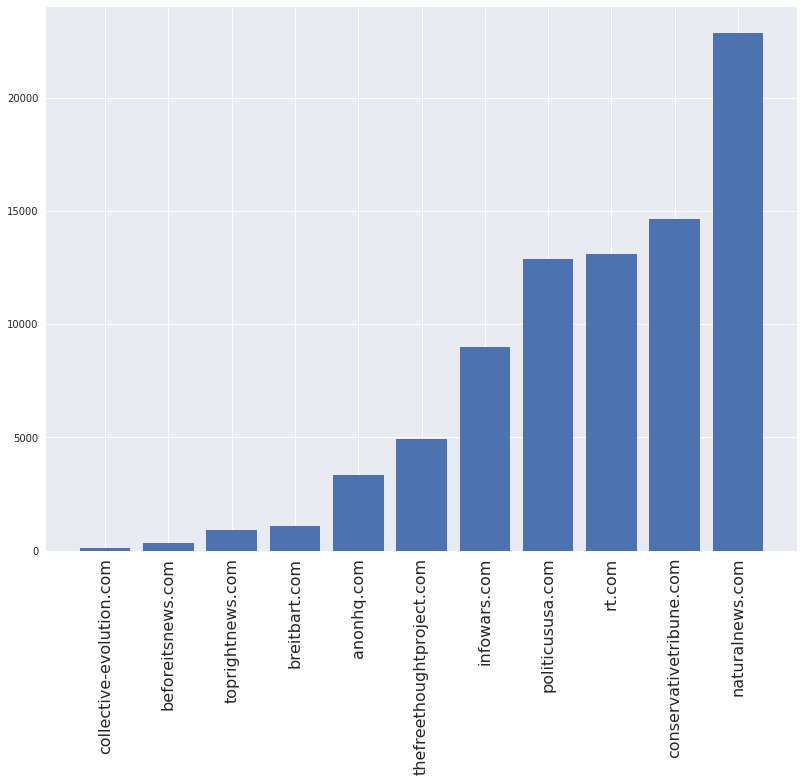

                           likes  shares  comments
site_url                                          
collective-evolution.com     138     138         3
beforeitsnews.com            336     336         0
toprightnews.com             912     912         0
breitbart.com               1082    1082         0
anonhq.com                  3348    3348         0
thefreethoughtproject.com   4939    4939        15
infowars.com                8977    8977         0
politicususa.com           12871   12871         0
rt.com                     13077   13077         0
conservativetribune.com    14659   14659       216
naturalnews.com            22853   22853         0


In [12]:
shared_data = data[['uuid', 'site_url', 'likes', 'shares', 'comments']]
shared_data = shared_data[(shared_data.likes>0) | (shared_data.shares>0) | (shared_data.comments>0)]
shared_data_counts = shared_data.groupby('site_url').sum().sort_values(by=['shares'])
print(shared_data_counts.columns)
# Weird that likes and share are exactly the same number
plt.figure(figsize=(12,10))
plt.bar(left=[x for x in range(len(shared_data_counts.likes))], height = list(shared_data_counts.shares))
plt.xticks([x for x in range(len(shared_data_counts.likes))], list(shared_data_counts.index), rotation="vertical", fontsize=16)
plt.show()
print(shared_data_counts)

Index(['likes', 'shares', 'comments'], dtype='object')


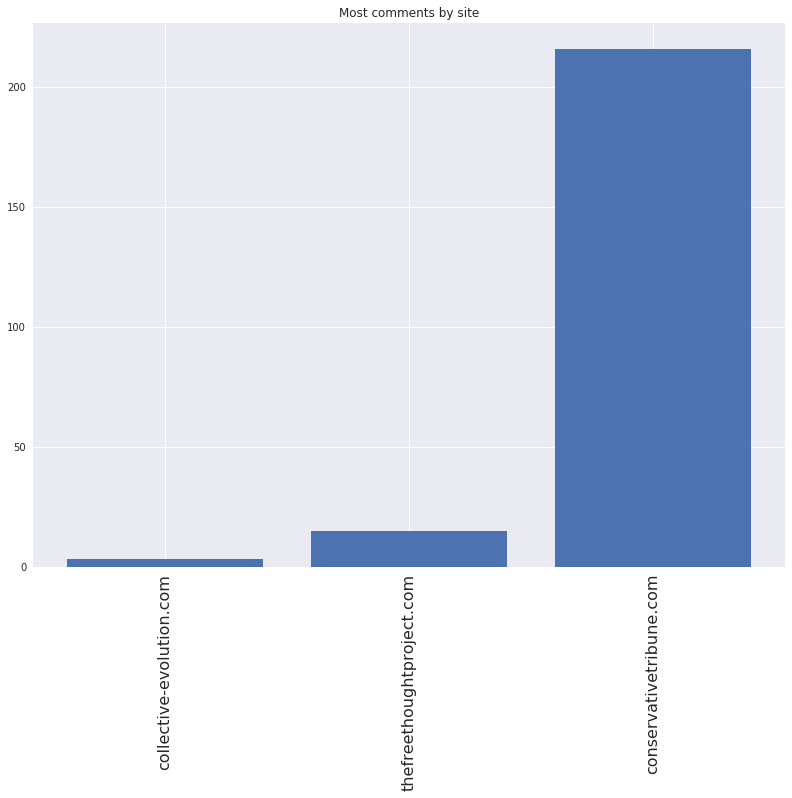

                           likes  shares  comments
site_url                                          
collective-evolution.com     138     138         3
thefreethoughtproject.com     95      95        15
conservativetribune.com    12531   12531       216


In [13]:
shared_data = data[['uuid', 'site_url', 'likes', 'shares', 'comments']]
shared_data = shared_data[(shared_data.comments>0)]
shared_data_counts = shared_data.groupby('site_url').sum().sort_values(by=['comments'])
print(shared_data_counts.columns)
# Weird that likes and share are exactly the same number
plt.figure(figsize=(12,10))
plt.bar(left=[x for x in range(len(shared_data_counts.comments))], height = list(shared_data_counts.comments))
plt.xticks([x for x in range(len(shared_data_counts.comments))], list(shared_data_counts.index), rotation="vertical", fontsize=16)
plt.title("Most comments by site")
plt.show()
print(shared_data_counts)

In [14]:
data[data.comments==data.comments.max()]

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
1769,3ff8858a956f846c57d5d08f33553d8ed9b0e786,0,John Falkenberg,2016-10-27T01:44:38.370+03:00,Trump Haters Boycott Ivanka’s Clothing Line Be...,"“That is what ‘Trump’ means to me,” she said. ...",english,2016-10-27T01:44:38.370+03:00,conservativetribune.com,US,486.0,Trump Haters Boycott Ivanka’s Clothing Line Be...,0.0,http://static.conservativetribune.com/wp-conte...,0,1,16,30,16,bs


Index(['likes', 'shares', 'comments'], dtype='object')


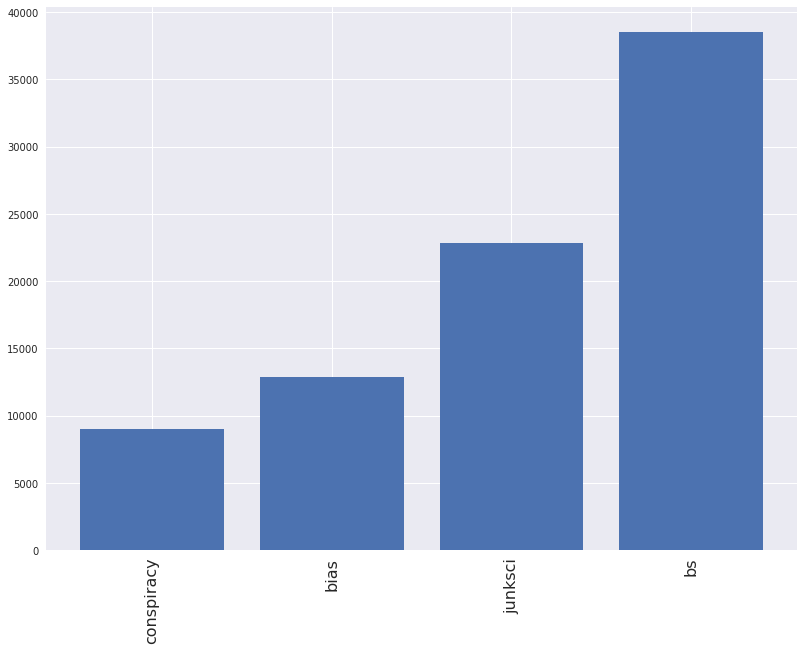

            likes  shares  comments
type                               
conspiracy   8977    8977         0
bias        12871   12871         0
junksci     22853   22853         0
bs          38491   38491       234


In [15]:
shared_data = data[['uuid', 'site_url', 'type', 'likes', 'shares', 'comments']]
shared_data = shared_data[(shared_data.likes>0) | (shared_data.shares>0) | (shared_data.comments>0)]
shared_data_counts = shared_data.groupby('type').sum().sort_values(by=['shares'])
print(shared_data_counts.columns)
# Weird that likes and share are exactly the same number
plt.figure(figsize=(12,10))
plt.bar(left=[x for x in range(len(shared_data_counts.likes))], height = list(shared_data_counts.shares))
plt.xticks([x for x in range(len(shared_data_counts.likes))], list(shared_data_counts.index), rotation="vertical", fontsize=16)
plt.show()
print(shared_data_counts)

In [16]:
get_topics(data.title)


Topics in NMF model (Frobenius norm):
Topic #0: hillary fbi watch emails investigation video obama weiner vote wikileaks michelle breaking
Topic #1: trump donald video supporter says president supporters media watch vote black voting
Topic #2: new eastern outlook investigation fbi york obama email report nuclear emails economic
Topic #3: election day 2016 chart america rigging audio violence one presidential americans stolen
Topic #4: clinton fbi campaign email wikileaks bill investigation emails foundation obama comment comey
Topic #5: us russia syria civilians isis mosul troops putin war world nato relations



Ok, so now that is done the topics we get here are very different from the typology presented in the dataset. 
Indeed they are actual topics covered in the dataset. We see that the Clinton e-mail scandal features on its own 
in two different topics - one that covers a more legal stance and one that focuses more on the scandal itself.
The Syrian civil war is there, and so is the Dacota pipeline as well as a topic related to health. What does not
emerge here is whether these are bias or hate or conspiracy focused,
and perhaps each shares a substantial number of articles(TODO).
One of the topic has a lot of words that suggest some cleanup is in order. 

The major take-away is that fake-news seem to follow the scandals and important events of the 
day and seem to connect with them. An exception to this would be the natural news topics, which would follow 
its own niche that does not necessary reflect the big news. 

We can in fact do the same topic analysis on each of the subgroups of fake news we have. 

TODO: Get normal news from the same period and run the same excercise. 

In [17]:
get_topics(junksci.text)


Topics in NMF model (Frobenius norm):
Topic #0: food organic people gmo waste china children year percent health products water
Topic #1: clinton trump election hillary america criminal clintons vote democrats democracy political media
Topic #2: vitamin water lemon juice body cholesterol heart tea garlic drink inflammation skin
Topic #3: cancer chemotherapy women breast ovarian johnson onions found researchers hospitals study cells
Topic #4: adams science metals heavy fake author com book food nutrition ranger journal
Topic #5: pipeline dakota police land access arrested government climate north public private conspiracy



In [18]:
get_topics(bs.text)


Topics in NMF model (Frobenius norm):
Topic #0: people one like would world also many time police even us said
Topic #1: clinton fbi hillary emails comey investigation email campaign weiner podesta director abedin
Topic #2: trump donald election hillary vote clinton republican campaign president voting voters supporters
Topic #3: russia russian syria us war military putin isis syrian mosul nuclear nato
Topic #4: october 2016 https 27 twitter 28 pic co com 26 hillary 29
Topic #5: david daily november day state 2016 data latest leading email mainstream posted



In [19]:
get_topics(bias.text)


Topics in NMF model (Frobenius norm):
Topic #0: trump donald election campaign republican president clinton women presidential nominee voters would
Topic #1: facebook account comment via article disqus follow us times political officer wing
Topic #2: clinton emails hillary email fbi campaign republicans investigation podesta server scandal news
Topic #3: found dead period israel woman century old ago said inside home police
Topic #4: comey fbi letter director election investigation james information emails partisan republicans hatch
Topic #5: percent points data poll showed 22 support economic lead market mins published



In [20]:
get_topics(hate.text)


Topics in NMF model (Frobenius norm):
Topic #0: fbi clinton hillary comey investigation department lynch doj emails campaign justice said
Topic #1: hillary clinton trump women percent obama president left people would one like
Topic #2: israel resolution palestinian jerusalem israeli unesco jewish pa palestinians obama anti nations
Topic #3: muslim muslims islam jihad splc religious islamic list christians tests cair muhammad
Topic #4: biden joe iran secretary iranian state senator bush fund make million 200
Topic #5: states united un cuba obama resolution policy ambassador cuban embargo america us



###